# Temperature transects through the Southern Ocean 

Trying to understand why Drake Passage transport in CM2 is substantially larger compared to OM2.

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
import numpy as np
%matplotlib inline

from xarray.ufuncs import isnan, sqrt#, isfinite, deg2rad, sin, cos, 

# Stop annoying warnings coming out of xarray.
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39619/status,
Dashboard: /proxy/39619/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43467,Workers: 7
Dashboard: /proxy/39619/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:40259,Total threads: 4
Dashboard: /proxy/39125/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:35381,


In [3]:
session_CM2 = cc.database.create_session('/g/data/p73/archive/non-CMIP/ACCESS-CM2/CM2.db')
control     = 'cj877'
expt_CM2_1  = 'bz687'

In [4]:
# OM2 database
#session_OM2  = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
session_OM2  = cc.database.create_session(db='/g/data/ik11/databases/cosima_master_2022-07-01.db')
expt_OM2_025 = '025deg_jra55_ryf9091_gadi'
expt_OM2_1   = '1deg_jra55_ryf9091_gadi'

If you get a 'read-only database' warning, it is because the database has not finished building. 

In [5]:
path_to_data = '/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/'

In [6]:
# Plotting info
ft_size = 16
plt.rcParams.update({'font.size': ft_size})

In [7]:
# White
import matplotlib
colorsList_white = [('white')]
CustumCmap_white = matplotlib.colors.ListedColormap(colorsList_white)

### Surface map

In [72]:
hu = cc.querying.getvar(control, 'hu', session_CM2, n=1)
hu = hu.sel(yu_ocean=slice(-90,-30))

land = xr.where(isnan(hu.rename('land')), 1, np.nan)

In [27]:
u = cc.querying.getvar(control, 'u', session_CM2, start_time='0100-01-01', end_time='0101-12-31', frequency='1 monthly')
u = u.sel(time=slice('0100-01-01', '0100-12-31')).sel(yu_ocean=slice(-90, -40)).sel(st_ocean=0, method="nearest")
v = cc.querying.getvar(control, 'v', session_CM2, start_time='0100-01-01', end_time='0101-12-31', frequency='1 monthly')
v = v.sel(time=slice('0100-01-01', '0100-12-31')).sel(yu_ocean=slice(-90, -40)).sel(st_ocean=0, method="nearest")

In [29]:
# Speed
speed = sqrt(u**2 + v**2)

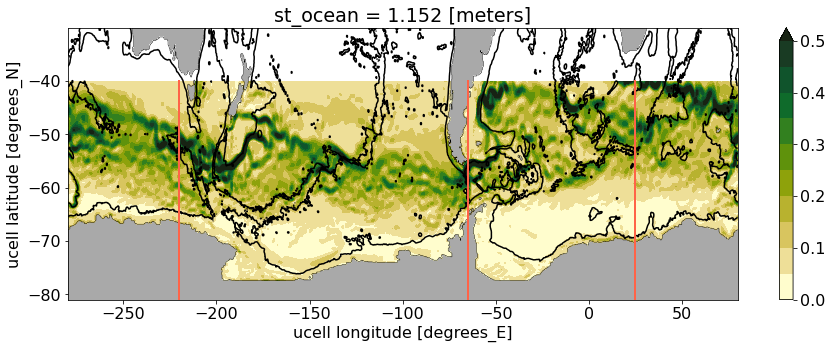

In [73]:
fig = plt.figure(figsize=(15,5))

# Land
land.plot.contourf(colors='darkgrey', add_colorbar=False)
# Coastline
land.fillna(0).plot.contour(colors='k', levels=[0, 1], add_colorbar=False, linewidths=0.5)
# Bathymetry in white (remove when plotting some other background variable)
(hu/hu).plot.contourf(levels=[0, 1], cmap=CustumCmap_white, add_labels=False, add_colorbar=False)
# More isobaths
hu.plot.contour(levels=[3000], colors='k')

plt.plot([-65, -65], [-81,-40.1], color='tomato', linewidth=2)
plt.plot([25, 25], [-81,-40.1], color='tomato', linewidth=2)
plt.plot([-220, -220], [-81,-40.1], color='tomato', linewidth=2)

speed.mean('time').plot.contourf(levels=np.arange(0,0.55,0.05), cmap=cm.cm.speed);

### CM2-025

In [68]:
%%time
temp = cc.querying.getvar(control, 'temp', session_CM2, start_time='0210-01-01', end_time='0219-12-31', frequency='1 monthly')
temp = temp.sel(time=slice('0210-01-01', '0219-12-31')).sel(yt_ocean=slice(-90,-40)) - 273.15
temp = temp.groupby('time.year').mean(dim='time').mean('year')
temp = temp.load()

rho2 = cc.querying.getvar(control, 'pot_rho_2', session_CM2, start_time='0210-01-01', end_time='0219-12-31', frequency='1 monthly')
rho2 = rho2.sel(time=slice('0210-01-01', '0219-12-31')).sel(yt_ocean=slice(-90,-40)) - 1000
rho2 = rho2.groupby('time.year').mean(dim='time').mean('year')
rho2 = rho2.load()

CPU times: user 44.1 s, sys: 2.31 s, total: 46.4 s
Wall time: 57.9 s


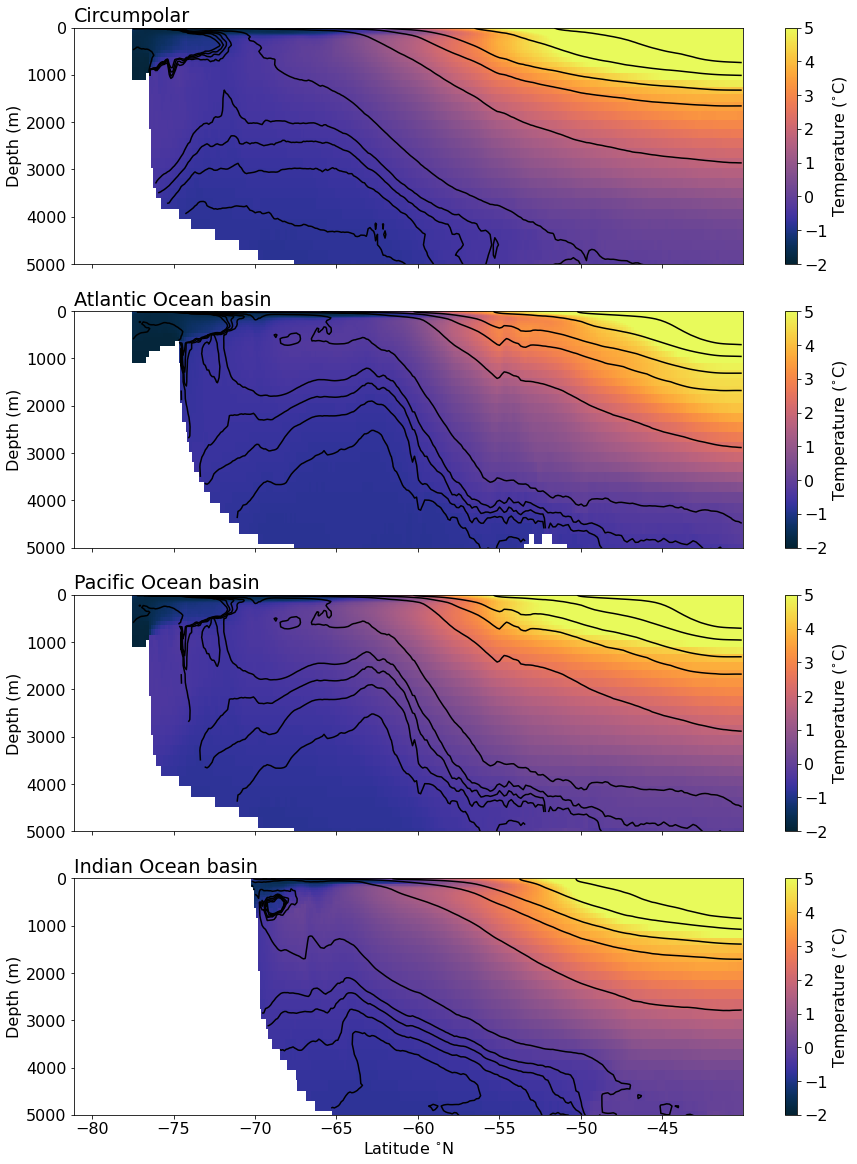

In [114]:
fig = plt.figure(figsize=(15,20))

rho_levels = [35.5, 36, 36.5, 36.75, 37, 37.2, 37.23, 37.24, 37.25, 37.26, 37.5]

def plot_transect(var, cnt, title_name, labelbottom=1):
    sc = plt.pcolormesh(temp.yt_ocean, temp.st_ocean, var, vmin=-2, vmax=5, cmap=cm.cm.thermal)
    plt.contour(temp.yt_ocean, temp.st_ocean, cnt, levels=rho_levels, colors='k')
    cbar = plt.colorbar(sc)
    cbar.set_label('Temperature ($^{\circ}$C)')
    plt.ylim(5000, 0)
    plt.ylabel('Depth (m)')
    plt.title(title_name, loc='left')
    if labelbottom == 0:
        plt.tick_params(labelbottom=False)
    elif labelbottom == 1:
        plt.xlabel('Latitude $^{\circ}$N')

# Circumpolar
plt.subplot(4,1,1)
var = temp.mean('xt_ocean')
cnt = rho2.mean('xt_ocean')
plot_transect(var, cnt, 'Circumpolar', 0)

# Atlantic basin
plt.subplot(4,1,2)
var = temp.sel(xt_ocean=slice(-65,25)).mean('xt_ocean')
sc = plt.pcolormesh(temp.yt_ocean, temp.st_ocean, var, vmin=-2, vmax=5, cmap=cm.cm.thermal)
cnt = rho2.sel(xt_ocean=slice(-65,25)).mean('xt_ocean')
plt.contour(temp.yt_ocean, temp.st_ocean, cnt, levels=rho_levels, colors='k')
cbar = plt.colorbar(sc)
cbar.set_label('Temperature ($^{\circ}$C)')
plt.ylim(5000, 0)
plt.ylabel('Depth (m)')
plt.tick_params(labelbottom=False)
plt.title('Atlantic Ocean basin', loc='left')

# Pacific basin
plt.subplot(4,1,3)
var = temp.sel(xt_ocean=slice(-220,65)).mean('xt_ocean')
sc = plt.pcolormesh(temp.yt_ocean, temp.st_ocean, var, vmin=-2, vmax=5, cmap=cm.cm.thermal)
cnt = rho2.sel(xt_ocean=slice(-220,65)).mean('xt_ocean')
plt.contour(temp.yt_ocean, temp.st_ocean, cnt, levels=rho_levels, colors='k')
cbar = plt.colorbar(sc)
cbar.set_label('Temperature ($^{\circ}$C)')
plt.ylim(5000, 0)
plt.ylabel('Depth (m)')
plt.tick_params(labelbottom=False)
plt.title('Pacific Ocean basin', loc='left')

# Indian Ocean basin
plt.subplot(4,1,4)
var = temp.where((temp.xt_ocean < -220) | (temp.xt_ocean > 25)).mean('xt_ocean')
sc = plt.pcolormesh(temp.yt_ocean, temp.st_ocean, var, vmin=-2, vmax=5, cmap=cm.cm.thermal)
cnt = rho2.where((temp.xt_ocean < -220) | (temp.xt_ocean > 25)).mean('xt_ocean')
plt.contour(temp.yt_ocean, temp.st_ocean, cnt, levels=rho_levels, colors='k')
cbar = plt.colorbar(sc)
cbar.set_label('Temperature ($^{\circ}$C)')
plt.ylim(5000, 0)
plt.ylabel('Depth (m)')
plt.xlabel('Latitude $^{\circ}$N')
plt.title('Indian Ocean basin', loc='left');

### Model comparison

In [8]:
def get_temp(expt, session, start_time, end_time, frequency='1 monthly'):
    temp = cc.querying.getvar(expt, 'temp', session, start_time=start_time, end_time=end_time, frequency=frequency)
    temp = temp.sel(time=slice(start_time, end_time)).sel(yt_ocean=slice(-90,-40)) - 273.15
    temp = temp.groupby('time.year').mean(dim='time').mean('year')
    temp = temp.load()

    rho = cc.querying.getvar(expt, 'pot_rho_0', session, start_time=start_time, end_time=end_time, frequency=frequency)
    rho = rho.sel(time=slice(start_time, end_time)).sel(yt_ocean=slice(-90,-40)) - 1000
    rho = rho.groupby('time.year').mean(dim='time').mean('year')
    rho = rho.load()

    return temp, rho

In [10]:
%%time
temp_CM2_1, rho_CM2_1 = get_temp(expt_CM2_1, session_CM2, '0210-01-01', '0219-12-31', frequency='1 monthly')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datet

CPU times: user 10.7 s, sys: 931 ms, total: 11.7 s
Wall time: 35.5 s


In [12]:
%%time
temp_OM2_1, rho_OM2_1 = get_temp(expt_OM2_1, session_OM2, '2190-01-01', '2199-12-31', frequency='1 yearly')

CPU times: user 967 ms, sys: 224 ms, total: 1.19 s
Wall time: 3.16 s


In [13]:
%%time
temp_OM2_025, rho_OM2_025 = get_temp(expt_OM2_025, session_OM2, '2190-01-01', '2199-12-31', frequency='1 yearly')

CPU times: user 4.93 s, sys: 507 ms, total: 5.44 s
Wall time: 8.06 s


In [14]:
%%time
temp_CM2_025, rho_CM2_025 = get_temp(control, session_CM2, '0210-01-01', '0219-12-31', frequency='1 monthly')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, cal

CPU times: user 54 s, sys: 3.53 s, total: 57.5 s
Wall time: 1min 16s


Circumpolar

In [ ]:
fig = plt.figure(figsize=(15,15))

rho_levels = [25.5, 26., 26.5, 27., 27.5, 27.6, 27.7, 27.8, 27.85, 27.86, 27.87, 27.88, 27.89, 27.9, 27.91, 28.]

def plot_transect(var, cnt, title_name, labelbottom=1):
    sc = plt.pcolormesh(var.yt_ocean, var.st_ocean, var, vmin=-2, vmax=5, cmap=cm.cm.thermal)
    plt.contour(var.yt_ocean, var.st_ocean, cnt, levels=rho_levels, colors='k')
    cbar = plt.colorbar(sc)
    cbar.set_label('Temperature ($^{\circ}$C)')
    plt.ylim(5000, 0)
    plt.ylabel('Depth (m)')
    plt.title(title_name, loc='left')
    if labelbottom == 0:
        plt.tick_params(labelbottom=False)
    elif labelbottom == 1:
        plt.xlabel('Latitude $^{\circ}$N')

# CM2-025
plt.subplot(4,1,1)
var = temp_CM2_025.mean('xt_ocean')
cnt = rho_CM2_025.mean('xt_ocean')
plot_transect(var, cnt, 'CM2-025', 0)

# OM2-025
plt.subplot(4,1,2)
var = temp_OM2_025.mean('xt_ocean')
cnt = rho_OM2_025.mean('xt_ocean')
plot_transect(var, cnt, 'OM2-025', 0)

# OM2-1
plt.subplot(4,1,3)
var = temp_OM2_1.mean('xt_ocean')
cnt = rho_OM2_1.mean('xt_ocean')
plot_transect(var, cnt, 'OM2-1', 0)

# OM2-1
plt.subplot(4,1,4)
var = temp_CM2_1.mean('xt_ocean')
cnt = rho_CM2_1.mean('xt_ocean')
plot_transect(var, cnt, 'CM2-1', 1)

Atlantic Ocean

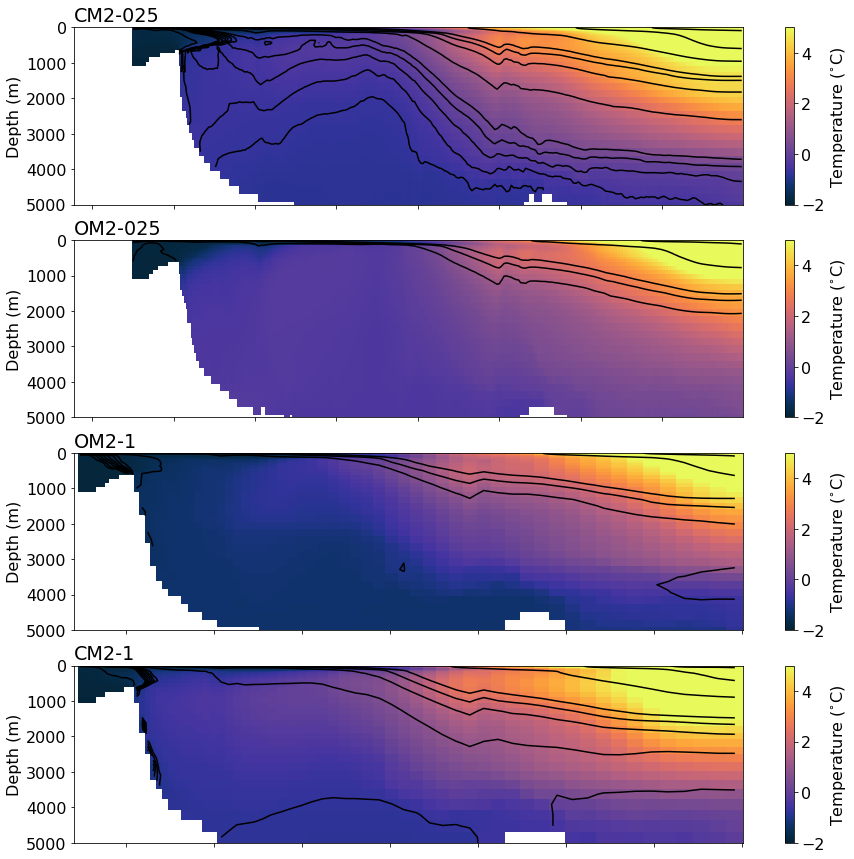

In [16]:
fig = plt.figure(figsize=(15,15))

rho_levels = [25.5, 26., 26.5, 27., 27.5, 27.6, 27.7, 27.8, 27.85, 27.86, 27.87, 27.88, 27.89, 27.9, 27.91, 28.]

def plot_transect(var, cnt, title_name, labelbottom=1):
    sc = plt.pcolormesh(var.yt_ocean, var.st_ocean, var, vmin=-2, vmax=5, cmap=cm.cm.thermal)
    plt.contour(var.yt_ocean, var.st_ocean, cnt, levels=rho_levels, colors='k')
    cbar = plt.colorbar(sc)
    cbar.set_label('Temperature ($^{\circ}$C)')
    plt.ylim(5000, 0)
    plt.ylabel('Depth (m)')
    plt.title(title_name, loc='left')
    if labelbottom == 0:
        plt.tick_params(labelbottom=False)
    elif labelbottom == 1:
        plt.xlabel('Latitude $^{\circ}$N')

# CM2-025
plt.subplot(4,1,1)
var = temp_CM2_025.sel(xt_ocean=slice(-65,25)).mean('xt_ocean')
cnt = rho_CM2_025.sel(xt_ocean=slice(-65,25)).mean('xt_ocean')
plot_transect(var, cnt, 'CM2-025', 0)

# OM2-025
plt.subplot(4,1,2)
var = temp_OM2_025.sel(xt_ocean=slice(-65,25)).mean('xt_ocean')
cnt = rho_OM2_025.sel(xt_ocean=slice(-65,25)).mean('xt_ocean')
plot_transect(var, cnt, 'OM2-025', 0)

# OM2-1
plt.subplot(4,1,3)
var = temp_OM2_1.sel(xt_ocean=slice(-65,25)).mean('xt_ocean')
cnt = rho_OM2_1.sel(xt_ocean=slice(-65,25)).mean('xt_ocean')
plot_transect(var, cnt, 'OM2-1', 0)

# CM2-1
plt.subplot(4,1,4)
var = temp_CM2_1.sel(xt_ocean=slice(-65,25)).mean('xt_ocean')
cnt = rho_CM2_1.sel(xt_ocean=slice(-65,25)).mean('xt_ocean')
plot_transect(var, cnt, 'CM2-1', 0)

Pacific Ocean

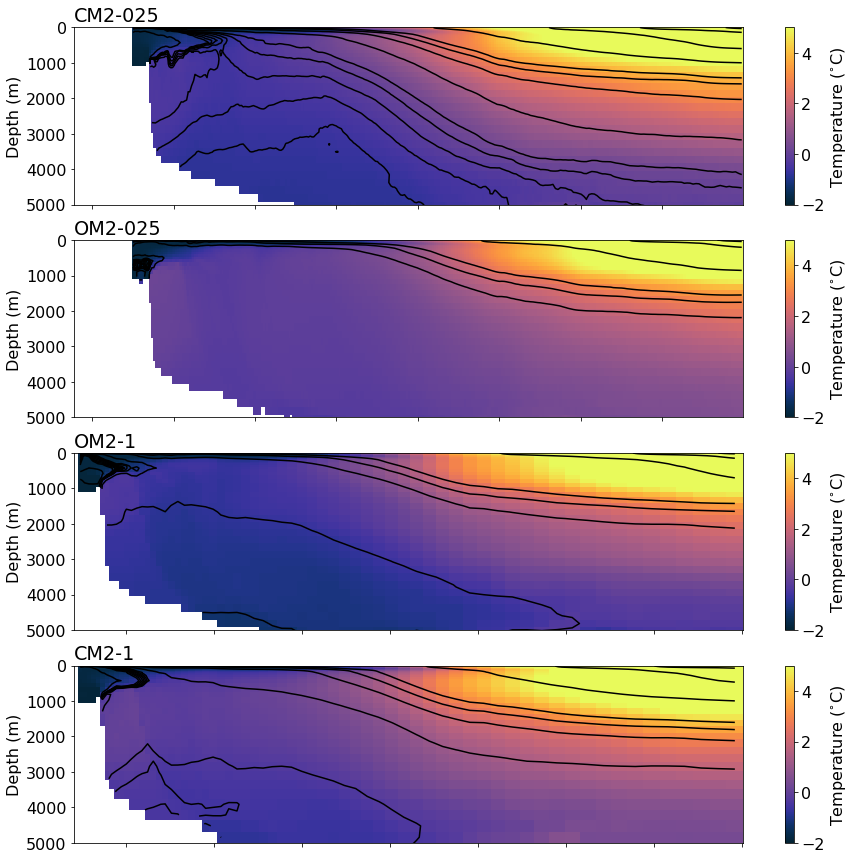

In [17]:
fig = plt.figure(figsize=(15,15))

rho_levels = [25.5, 26., 26.5, 27., 27.5, 27.6, 27.7, 27.8, 27.85, 27.86, 27.87, 27.88, 27.89, 27.9, 27.91, 28.]

def plot_transect(var, cnt, title_name, labelbottom=1):
    sc = plt.pcolormesh(var.yt_ocean, var.st_ocean, var, vmin=-2, vmax=5, cmap=cm.cm.thermal)
    plt.contour(var.yt_ocean, var.st_ocean, cnt, levels=rho_levels, colors='k')
    cbar = plt.colorbar(sc)
    cbar.set_label('Temperature ($^{\circ}$C)')
    plt.ylim(5000, 0)
    plt.ylabel('Depth (m)')
    plt.title(title_name, loc='left')
    if labelbottom == 0:
        plt.tick_params(labelbottom=False)
    elif labelbottom == 1:
        plt.xlabel('Latitude $^{\circ}$N')

# CM2-025
plt.subplot(4,1,1)
var = temp_CM2_025.sel(xt_ocean=slice(-220,65)).mean('xt_ocean')
cnt = rho_CM2_025.sel(xt_ocean=slice(-220,65)).mean('xt_ocean')
plot_transect(var, cnt, 'CM2-025', 0)

# OM2-025
plt.subplot(4,1,2)
var = temp_OM2_025.sel(xt_ocean=slice(-220,65)).mean('xt_ocean')
cnt = rho_OM2_025.sel(xt_ocean=slice(-220,65)).mean('xt_ocean')
plot_transect(var, cnt, 'OM2-025', 0)

# OM2-1
plt.subplot(4,1,3)
var = temp_OM2_1.sel(xt_ocean=slice(-220,65)).mean('xt_ocean')
cnt = rho_OM2_1.sel(xt_ocean=slice(-220,65)).mean('xt_ocean')
plot_transect(var, cnt, 'OM2-1', 0)

# OM2-1
plt.subplot(4,1,4)
var = temp_CM2_1.sel(xt_ocean=slice(-220,65)).mean('xt_ocean')
cnt = rho_CM2_1.sel(xt_ocean=slice(-220,65)).mean('xt_ocean')
plot_transect(var, cnt, 'CM2-1', 0)

Indian Ocean

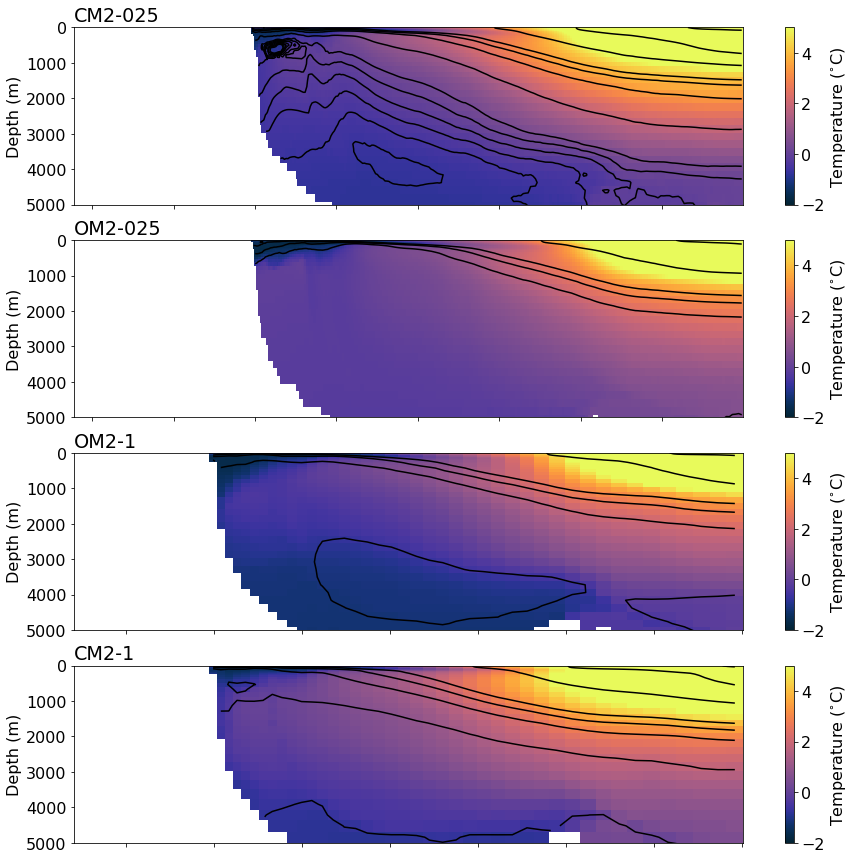

In [18]:
fig = plt.figure(figsize=(15,15))

rho_levels = [25.5, 26., 26.5, 27., 27.5, 27.6, 27.7, 27.8, 27.85, 27.86, 27.87, 27.88, 27.89, 27.9, 27.91, 28.]

def plot_transect(var, cnt, title_name, labelbottom=1):
    sc = plt.pcolormesh(var.yt_ocean, var.st_ocean, var, vmin=-2, vmax=5, cmap=cm.cm.thermal)
    plt.contour(var.yt_ocean, var.st_ocean, cnt, levels=rho_levels, colors='k')
    cbar = plt.colorbar(sc)
    cbar.set_label('Temperature ($^{\circ}$C)')
    plt.ylim(5000, 0)
    plt.ylabel('Depth (m)')
    plt.title(title_name, loc='left')
    if labelbottom == 0:
        plt.tick_params(labelbottom=False)
    elif labelbottom == 1:
        plt.xlabel('Latitude $^{\circ}$N')

# CM2-025
plt.subplot(4,1,1)
var = temp_CM2_025.where((temp_CM2_025.xt_ocean < -220) | (temp_CM2_025.xt_ocean > 25)).mean('xt_ocean')
cnt = rho_CM2_025.where((rho_CM2_025.xt_ocean < -220) | (rho_CM2_025.xt_ocean > 25)).mean('xt_ocean')
plot_transect(var, cnt, 'CM2-025', 0)

# OM2-025
plt.subplot(4,1,2)
var = temp_OM2_025.where((temp_OM2_025.xt_ocean < -220) | (temp_OM2_025.xt_ocean > 25)).mean('xt_ocean')
cnt = rho_OM2_025.where((rho_OM2_025.xt_ocean < -220) | (rho_OM2_025.xt_ocean > 25)).mean('xt_ocean')
plot_transect(var, cnt, 'OM2-025', 0)

# OM2-1
plt.subplot(4,1,3)
var = temp_OM2_1.where((temp_OM2_1.xt_ocean < -220) | (temp_OM2_1.xt_ocean > 25)).mean('xt_ocean')
cnt = rho_OM2_1.where((rho_OM2_1.xt_ocean < -220) | (rho_OM2_1.xt_ocean > 25)).mean('xt_ocean')
plot_transect(var, cnt, 'OM2-1', 0)

# CM2-1
plt.subplot(4,1,4)
var = temp_CM2_1.where((temp_CM2_1.xt_ocean < -220) | (temp_CM2_1.xt_ocean > 25)).mean('xt_ocean')
cnt = rho_CM2_1.where((rho_CM2_1.xt_ocean < -220) | (rho_CM2_1.xt_ocean > 25)).mean('xt_ocean')
plot_transect(var, cnt, 'CM2-1', 0)

Difference between 025 models

''

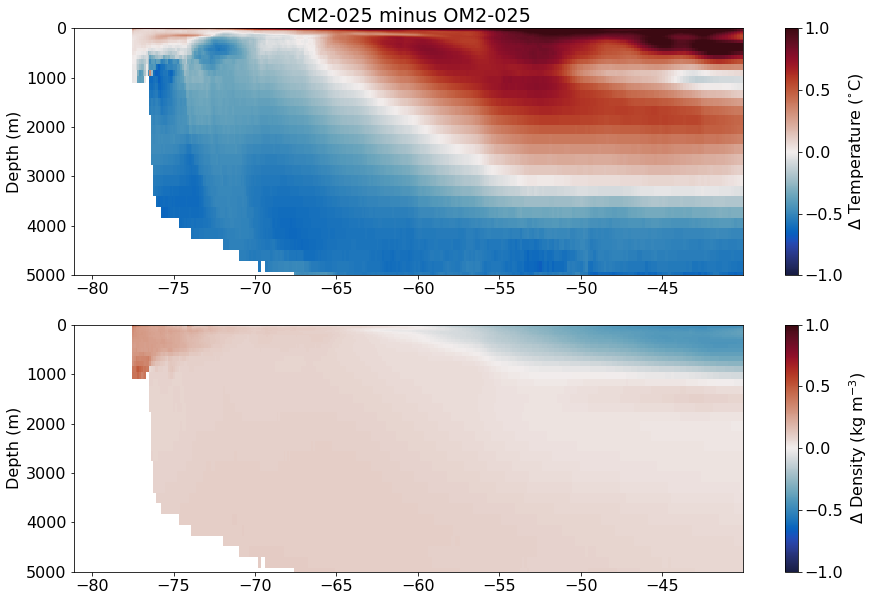

In [31]:
fig = plt.figure(figsize=(15,10))

rho_levels = [25.5, 26., 26.5, 27., 27.5, 27.6, 27.7, 27.8, 27.85, 27.86, 27.87, 27.88, 27.89, 27.9, 27.91, 28.]

# def plot_transect(var, cnt, title_name, labelbottom=1):
#     sc = plt.pcolormesh(var.yt_ocean, var.st_ocean, var, vmin=-2, vmax=5, cmap=cm.cm.thermal)
#     plt.contour(var.yt_ocean, var.st_ocean, cnt, levels=rho_levels, colors='k')
#     cbar = plt.colorbar(sc)
#     cbar.set_label('Temperature ($^{\circ}$C)')
#     plt.ylim(5000, 0)
#     plt.ylabel('Depth (m)')
#     plt.title(title_name, loc='left')
#     if labelbottom == 0:
#         plt.tick_params(labelbottom=False)
#     elif labelbottom == 1:
#         plt.xlabel('Latitude $^{\circ}$N')

# plot_transect(var, cnt, 'OM2-025', 0)

plt.subplot(211)
var = temp_CM2_025.mean('xt_ocean') - temp_OM2_025.mean('xt_ocean').values
sc  = plt.pcolormesh(var.yt_ocean, var.st_ocean, var, vmin=-1, vmax=1, cmap=cm.cm.balance)
cbar = plt.colorbar(sc)
cbar.set_label('$\Delta$ Temperature ($^{\circ}$C)')
plt.ylim(5000, 0)
plt.ylabel('Depth (m)')
plt.title('CM2-025 minus OM2-025')

plt.subplot(212)
var = rho_CM2_025.mean('xt_ocean') - rho_OM2_025.mean('xt_ocean').values
sc  = plt.pcolormesh(var.yt_ocean, var.st_ocean, var, vmin=-1, vmax=1, cmap=cm.cm.balance)
cbar = plt.colorbar(sc)
cbar.set_label('$\Delta$ Density (kg m$^{-3}$)')
plt.ylim(5000, 0)
plt.ylabel('Depth (m)');